Convolutional Visual Transformer
===

***
# <span style="color:lightblue"> Preamble

This notebook Is a starting point for the Semester Project in ECE 538 image analysis and computer vision II. The 

Leclerc S, Smistad E, Pedrosa J, Østvik A, Cervenansky F, Espinosa F, Espeland T, Rye Berg EA, Jodoin PM, Grenier T, Lartizien C, D’hooge J, Lovstakken L, Bernard O. "Deep Learning for Segmentation using an Open Large-Scale Dataset in 2D Echocardiography" IEEE Trans Med Imaging, 2019:38:2198-2210, DOI: 10.1109/TMI.2019.2900516
    
# <span style="color:lightblue"> Objectives

Learn about visual transformers and apply it to medical imaging 
    
***
    

## Import python librairies


In [1]:
import logging
from pathlib import Path
from typing import Any, Dict, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import logging
from pathlib import Path
from typing import Any, Dict, Tuple

import numpy as np
import PIL
import SimpleITK as sitk
from PIL.Image import Resampling
from skimage.measure import find_contours
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, f1_score



import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [11]:
def sitk_load(filepath: str | Path) -> Tuple[np.ndarray, Dict[str, Any]]:
    """Loads an image using SimpleITK and returns the image and its metadata.

    Args:
        filepath: Path to the image.

    Returns:
        - ([N], H, W), Image array.
        - Collection of metadata.
    """
    # Load image and save info
    image = sitk.ReadImage(str(filepath))
    info = {"origin": image.GetOrigin(), "spacing": image.GetSpacing(), "direction": image.GetDirection()}

    # Extract numpy array from the SimpleITK image object
    im_array = np.squeeze(sitk.GetArrayFromImage(image))

    return im_array, info

In [3]:
###########################################
# PARAMETERS TO PLAY WITH

database_nifti_root = Path("./data")
lv_label = 1
# Select the patient identification (scalar value between 1 and 500)
patient_id = 237

print(database_nifti_root)

# Specify the ID and path of the patient to be loaded
patient_name = f"patient{patient_id:04d}"
patient_dir = database_nifti_root / patient_name
gt_mask_pattern = "{patient_name}_{view}_{instant}_gt.nii.gz"
print(f"Loading data from patient folder: {patient_dir}")



data
Loading data from patient folder: data/patient0237


In [ ]:
view = "2CH"
instant = "ED"
a2c_ed, a2c_info = sitk_load(patient_dir / gt_mask_pattern.format(patient_name=patient_name, view=view, instant=instant))
a2c_voxelspacing = a2c_info["spacing"][:2][::-1]    # Extract the (width,height) dimension from the metadata and order them like in the mask

In [ ]:
instant = "ES"
a2c_es, _ = sitk_load(patient_dir / gt_mask_pattern.format(patient_name=patient_name, view=view, instant=instant))

In [ ]:
view = "4CH"
instant = "ED"
a4c_ed, a4c_info = sitk_load(patient_dir / gt_mask_pattern.format(patient_name=patient_name, view=view, instant=instant))
a4c_voxelspacing = a4c_info["spacing"][:2][::-1]    # Extract the (width,height) dimension from the metadata and order them like in the mask

In [ ]:
instant = "ES"
a4c_es, _ = sitk_load(patient_dir / gt_mask_pattern.format(patient_name=patient_name, view=view, instant=instant))

In [5]:
def load_echo_image(patient_dir, patient_name, view, instant):
    """Load original echocardiographic image"""
    img_pattern = f"{patient_name}_{view}_{instant}.nii.gz"
    img, _ = sitk_load(patient_dir / img_pattern)
    return img

(552, 669)
(552, 669)
(552, 669)
(552, 669)
(552, 669)
(552, 669)
(552, 669)
(552, 669)


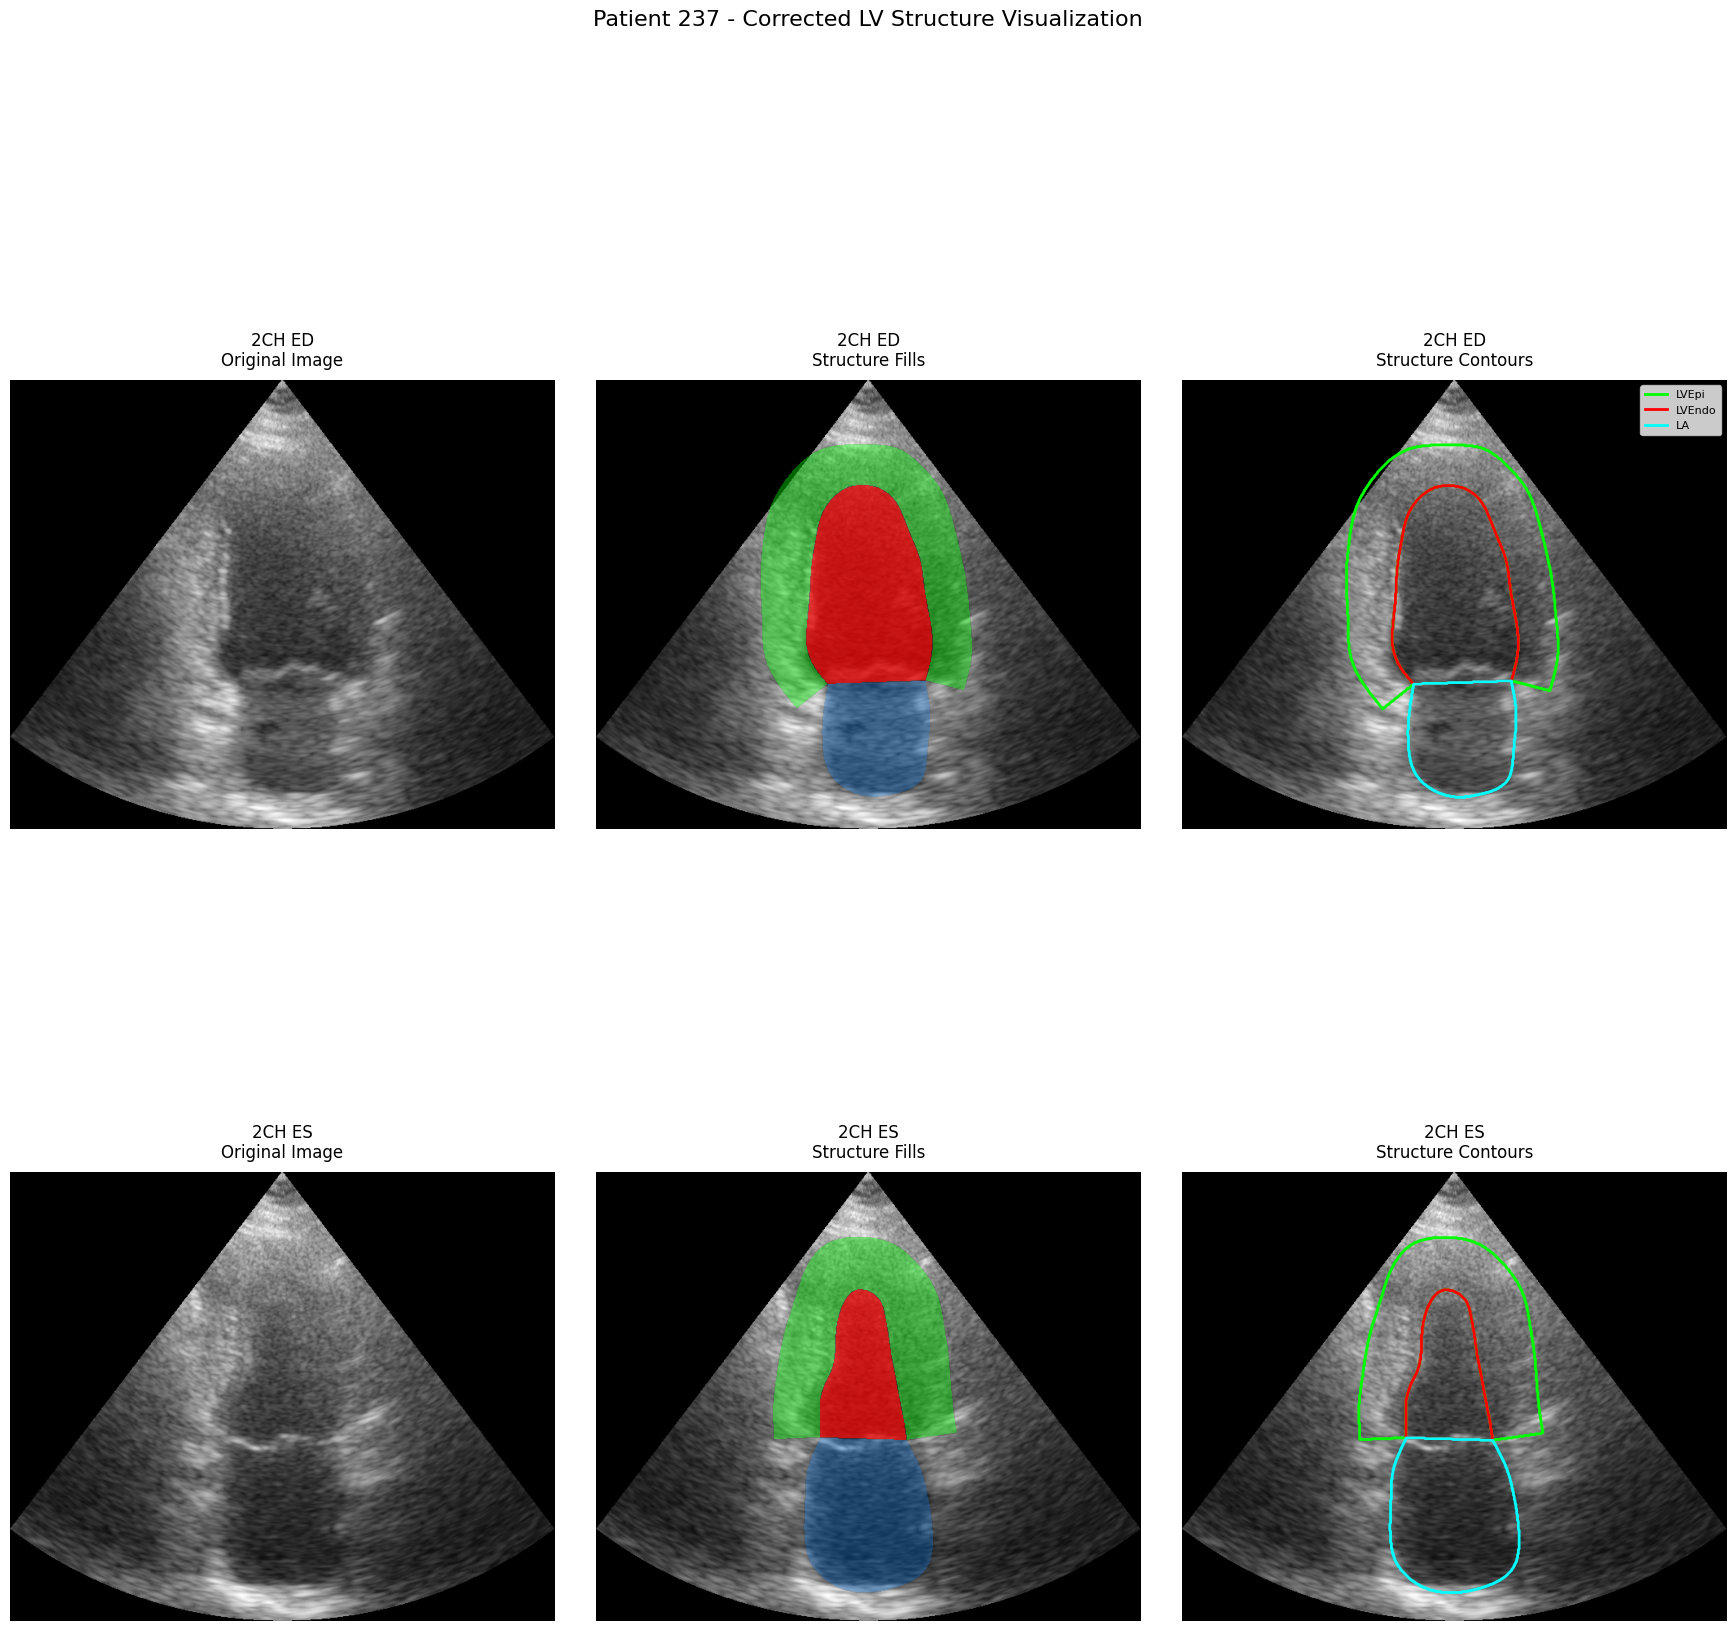

In [13]:
lvendo_cmap = ListedColormap([[0, 0, 0, 0], [1, 0, 0, 0.7]])  # Solid red for ENDOcardium
lvepi_cmap = ListedColormap([[0, 0, 0, 0], [0, 1, 0, 0.4]])    # Semi-transparent green for EPIcardium
la_cmap = ListedColormap([[0, 0, 0, 0], [0, 0.5, 1, 0.3]])     # Light blue for LA

def load_all_masks(patient_dir, patient_name, view, instant):
    """Load all masks with proper structure labels"""
    mask, info = sitk_load(patient_dir / f"{patient_name}_{view}_{instant}_gt.nii.gz")
    return {
        'LVendo': mask == 1,  # Inner blood pool boundary
        'LVepi': mask == 2,   # Outer heart wall boundary
        'LA': mask == 3,      # Left atrium
        'spacing': info['spacing'][:2][::-1]
    }

# Create figure with improved layout
fig, axes = plt.subplots(2, 3, figsize=(18, 20))# make 4,3 if include 4CH in views
fig.suptitle(f"Patient {patient_id} - Corrected LV Structure Visualization", fontsize=16, y=0.98)

views =  ["2CH"]#["2CH", "4CH"] change subplots to 4,3 if add in 4CH 
instants = ["ED", "ES"]

for i, (view, instant) in enumerate([(v, t) for v in views for t in instants]):
    # Load data
    img = load_echo_image(patient_dir, patient_name, view, instant)
    masks = load_all_masks(patient_dir, patient_name, view, instant)
    
    print(img.shape)
    
    print(masks['LVepi'].shape)
    print(masks['LVendo'].shape)
    print(masks['LA'].shape)

    # Column 1: Original image
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f"{view} {instant}\nOriginal Image", pad=10)
    axes[i, 0].axis('off')
    
    # Column 2: Fill visualization (corrected order)
    axes[i, 1].imshow(img, cmap='gray')
    axes[i, 1].imshow(masks['LVepi'], cmap=lvepi_cmap)  # EPI first (outer)
    axes[i, 1].imshow(masks['LVendo'], cmap=lvendo_cmap)  # ENDO second (inner)
    axes[i, 1].imshow(masks['LA'], cmap=la_cmap)
    axes[i, 1].set_title(f"{view} {instant}\nStructure Fills", pad=10)
    axes[i, 1].axis('off')
    
    # Column 3: Corrected contour visualization
    axes[i, 2].imshow(img, cmap='gray')
    
    # Plot EPI first (outer contour)
    epi_contours = find_contours(masks['LVepi'], 0.5)
    for contour in epi_contours:
        axes[i, 2].plot(contour[:, 1], contour[:, 0], linewidth=2, color='lime', label='LVEpi' if i==0 else "")
    
    # Then plot ENDO (inner contour)
    endo_contours = find_contours(masks['LVendo'], 0.5)
    for contour in endo_contours:
        axes[i, 2].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red', label='LVEndo' if i==0 else "")
    
    # Finally plot LA
    la_contours = find_contours(masks['LA'], 0.5)
    for contour in la_contours:
        axes[i, 2].plot(contour[:, 1], contour[:, 0], linewidth=2, color='cyan', label='LA' if i==0 else "")
    
    axes[i, 2].set_title(f"{view} {instant}\nStructure Contours", pad=10)
    axes[i, 2].axis('off')
    
    # Add legend only once
    if i == 0:
        axes[i, 2].legend(loc='upper right', fontsize=8)

plt.tight_layout(pad=3.0)
plt.show()


In [12]:
# Convolutional Visual Transformer for Cardiac Ultrasound Segmentation

class ConvBlock(nn.Module):
    """Convolutional block with batch norm and ReLU"""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))

class PatchEmbedding(nn.Module):
    """Convert image to patches using convolutional layers"""
    def __init__(self, in_channels=1, embed_dim=128, patch_size=16):
        super().__init__()
        self.proj = nn.Sequential(
            ConvBlock(in_channels, embed_dim//4, 7, 3),
            ConvBlock(embed_dim//4, embed_dim//2, 3, 1),
            ConvBlock(embed_dim//2, embed_dim, 3, 1),
            nn.MaxPool2d(kernel_size=patch_size//8, stride=patch_size//8)
        )
        
    def forward(self, x):
        x = self.proj(x)  # [B, C, H, W] -> [B, embed_dim, H', W']
        return rearrange(x, 'b c h w -> b (h w) c')  # Flatten to sequence

class TransformerBlock(nn.Module):
    """Transformer block with multi-head attention"""
    def __init__(self, embed_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim*4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim*4, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # Self-attention
        res = x
        x = self.norm1(x)
        x, _ = self.attn(x, x, x)
        x = res + x
        
        # MLP
        res = x
        x = self.norm2(x)
        x = res + self.mlp(x)
        return x

class CVT(nn.Module):
    """Convolutional Visual Transformer for cardiac segmentation"""
    def __init__(self, in_channels=1, num_classes=4, embed_dim=128, 
                 num_heads=4, num_layers=4, patch_size=16):
        super().__init__()
        
        # 1. Patch embedding with convs
        self.patch_embed = PatchEmbedding(in_channels, embed_dim, patch_size)
        
        # 2. Transformer encoder
        self.transformer = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads) 
            for _ in range(num_layers)
        ])
        
        # 3. Decoder with transposed convs
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, embed_dim//2, 4, 2, 1),
            ConvBlock(embed_dim//2, embed_dim//4),
            nn.ConvTranspose2d(embed_dim//4, embed_dim//8, 4, 2, 1),
            ConvBlock(embed_dim//8, embed_dim//16),
            nn.Conv2d(embed_dim//16, num_classes, 1)
        )
        
    def forward(self, x):
        B, C, H, W = x.shape
        
        # 1. Encode with conv + transformer
        x = self.patch_embed(x)  # [B, N, embed_dim]
        x = self.transformer(x)
        
        # 2. Reshape back to spatial
        h, w = H // self.patch_embed.proj[-1].stride, W // self.patch_embed.proj[-1].stride
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        
        # 3. Decode with transposed convs
        x = self.decoder(x)
        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=False)
        
        return x

# Dataset Class
class CardiacDataset(Dataset):
    def __init__(self, root_dir, view="2CH", instant="ED", transform=None):
        self.root_dir = Path(root_dir)
        # Create patient directories with proper 1-based indexing
        self.patient_dirs = [
            root_dir / f"patient{idx:04d}" 
            for idx in range(1, 501)  # Explicitly 1-500
            if (root_dir / f"patient{idx:04d}").exists()
        ]
        self.view = view
        self.instant = instant
        self.transform = transform
        
    def __len__(self):
        return len(self.patient_dirs)
    
    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]
        patient_name = patient_dir.name
        
        # Load image and mask
        img = load_echo_image(patient_dir, patient_name, self.view, self.instant)
        mask, _ = sitk_load(patient_dir / f"{patient_name}_{self.view}_{self.instant}_gt.nii.gz")
        
        # Convert to tensors
        img = torch.FloatTensor(img).unsqueeze(0)  # Add channel dim
        mask = torch.LongTensor(mask)  # Class indices 0-3
        
        # Normalize
        img = (img - img.min()) / (img.max() - img.min())
        
        if self.transform:
            img = self.transform(img)
            
        return img, mask

# Training Setup
def train_model(model, dataset, device, save_path):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.1, 1.0, 1.5, 1.0]).to(device))
    
    # Create dataset with error handling
    try:
        dataset = CardiacDataset(database_nifti_root)
        print(f"Dataset loaded with {len(dataset)} samples")
    except Exception as e:
        print(f"Dataset loading failed: {e}")
        return

    # Create DataLoader with pinned memory
    train_loader = DataLoader(
        dataset,
        batch_size=4,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    # Verify first batch
    try:
        test_batch = next(iter(train_loader))
        print("DataLoader test passed")
    except Exception as e:
        print(f"DataLoader test failed: {e}")
        return

    # Training loop
    for epoch in range(50):
        model.train()
        running_loss = 0.0
        
        for batch_idx, batch_data in enumerate(train_loader):
            try:
                # Handle cases where DataLoader returns unexpected formats
                if isinstance(batch_data, (list, tuple)) and len(batch_data) == 2:
                    images, masks = batch_data
                else:
                    print(f"Unexpected batch format at batch {batch_idx}")
                    continue
                
                # Verify shapes
                if images.dim() != 4 or masks.dim() != 3:
                    print(f"Invalid shapes at batch {batch_idx}: images {images.shape}, masks {masks.shape}")
                    continue
                
                # Transfer to device
                images, masks = images.to(device), masks.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                if batch_idx % 10 == 0:
                    print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')
                    
            except RuntimeError as e:
                if 'CUDA out of memory' in str(e):
                    print(f"CUDA OOM at batch {batch_idx}, reducing batch size")
                    torch.cuda.empty_cache()
                else:
                    print(f"RuntimeError at batch {batch_idx}: {e}")
                continue
        
        # Save after each epoch
        torch.save(model.state_dict(), save_path)
        print(f"Saved weights to {save_path}") 

        print(f'Epoch {epoch} complete, Avg Loss: {running_loss/len(train_loader):.4f}')
    
    print("Training completed successfully")

# Validation Function
def validate_model(model, dataset, device):
    model.eval()
    all_true, all_pred = [], []
    
    with torch.no_grad():
        for img, mask in DataLoader(dataset, batch_size=8):
            pred = torch.argmax(model(img.to(device)), dim=1)
            all_true.append(mask.flatten())
            all_pred.append(pred.cpu().flatten())
    
    all_true = torch.cat(all_true).numpy()
    all_pred = torch.cat(all_pred).numpy()
    
    print("Confusion Matrix:")
    print(confusion_matrix(all_true, all_pred, labels=[0,1,2,3]))
    
    print("\nF1 Scores:")
    for i, name in enumerate(["Background", "LVendo", "LVepi", "LA"]):
        print(f"{name}: {f1_score(all_true==i, all_pred==i):.3f}")


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
     
    weights_path = "cvt_cardiac_weights.pth"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 1. Initialize model
    model = CVT(in_channels=1, num_classes=4).to(device)

    dataset = CardiacDataset(database_nifti_root)
    

    if Path(weights_path).exists():
        print("Loading existing weights...")
        model.load_state_dict(torch.load(weights_path, map_location=device))
    else:
        print("Training new model...")
        train_model(model, dataset, device, weights_path)
    
    validate_model(model, dataset, device)

if __name__ == "__main__":
    main()

Training new model...
Dataset loaded with 500 samples


DataLoader test failed: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/lm/miniforge3/envs/ECE538/lib/python3.13/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/lm/miniforge3/envs/ECE538/lib/python3.13/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ~~~~~~~~~~~~~~~^^^^^^
  File "/home/lm/miniforge3/envs/ECE538/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/lm/miniforge3/envs/ECE538/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
    ~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lm/miniforge3/envs/ECE538/lib/python3.13/site-pa

RuntimeError: stack expects each tensor to be equal size, but got [1, 389, 549] at entry 0 and [1, 584, 748] at entry 1